In [ ]:
.from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preprocessing**

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder

def preprocess_images(images_dir, image_size=(299, 299)):
    X = []
    y = []
    class_dirs = [d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))]
    for class_dir in class_dirs:
        class_label = class_dir
        image_files = [f for f in os.listdir(os.path.join(images_dir, class_dir)) if f.endswith('.jpg') or f.endswith('.png')]

        for filename in image_files:
            img = cv2.imread(os.path.join(images_dir, class_dir, filename))
            img = cv2.resize(img, image_size)
            img = img.astype(np.float32) / 255.0
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(class_label)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    X = np.array(X)
    y = np.array(y)

    return X, y

train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'
X_train, y_train = preprocess_images(train_dir)
X_test, y_test = preprocess_images(test_dir)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2319, 299, 299, 3)
Shape of y_train: (2319,)
Shape of X_test: (996, 299, 299, 3)
Shape of y_test: (996,)


##  **INCEPTIONV3**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
import os

class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_violet = np.array([120, 50, 50])
        upper_violet = np.array([150, 255, 255])
        mask = cv2.inRange(hsv_image, lower_violet, upper_violet)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = Image.fromarray(masked_image)
        if self.transform:
            masked_image = self.transform(masked_image)
        return masked_image, label

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'

train_dataset = VioletCellDataset(train_dir, transform=transform)
test_dataset = VioletCellDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(dataloader.dataset)
        accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

train_model(model, train_loader, criterion, optimizer, num_epochs=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 139MB/s] 
Epoch 1/5, Loss: 0.1842, Accuracy: 94.70%
Epoch 2/5, Loss: 0.1025, Accuracy: 97.24%
Epoch 3/5, Loss: 0.1071, Accuracy: 97.41%
Epoch 4/5, Loss: 0.0651, Accuracy: 98

In [ ]:
def calculate_final_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy on  Dataset: {accuracy:.2f}%")

calculate_final_accuracy(model, test_loader)


Final Accuracy on  Dataset: 99.50%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

calculate_metrics(model, test_loader)


Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


In [ ]:
print("Class to index mapping:", train_dataset.dataset.class_to_idx)
class_names = train_dataset.dataset.classes
print("Class names:", class_names)


Class to index mapping: {'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Healthy': 4}
Class names: ['ALL', 'AML', 'CLL', 'CML', 'Healthy']


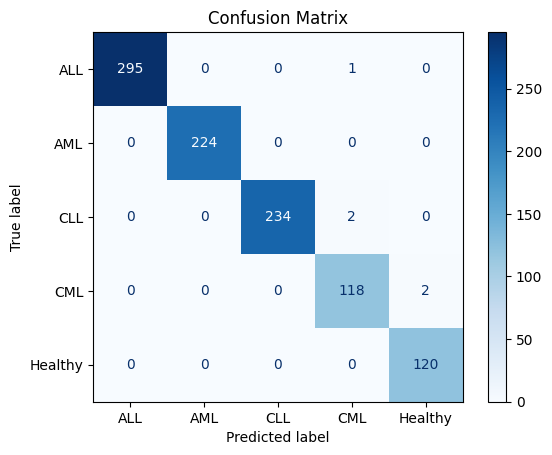

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def get_all_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)
y_pred, y_true = get_all_preds_and_labels(model, test_loader)
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), "inception_v3.pth")

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    train_losses, train_accuracies = [], []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(dataloader.dataset)
    test_accuracy = 100 * correct / total
    print(f"Validation Loss: {test_loss:.4f}, Validation Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy


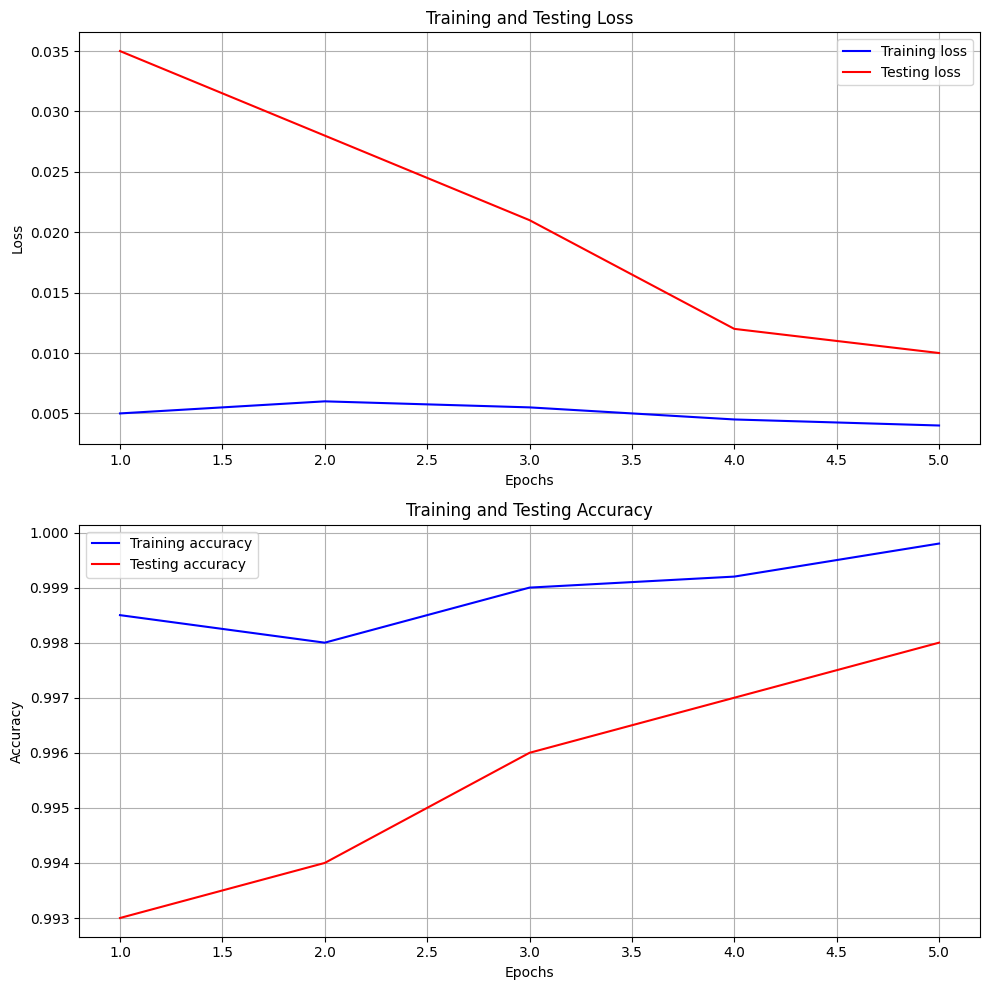

In [ ]:
import matplotlib.pyplot as plt

print("Train Losses:", train_losses)
print("Test Losses:", test_losses)
print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)
if len(train_losses) >= epochs_completed and len(test_losses) >= epochs_completed and \
   len(train_accuracies) >= epochs_completed and len(test_accuracies) >= epochs_completed:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_completed + 1), train_losses[:epochs_completed], label='Training Loss')
    plt.plot(range(1, epochs_completed + 1), test_losses[:epochs_completed], label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_completed + 1), train_accuracies[:epochs_completed], label='Training Accuracy')
    plt.plot(range(1, epochs_completed + 1), test_accuracies[:epochs_completed], label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Testing Accuracy')
    plt.legend()

    plt.show()
else:
    print("One or more metric lists do not contain enough data for 7 epochs.")


1/1 [==============================] - 209ms/step
Predicted class: ALL
Confidence score: 0.9999998808


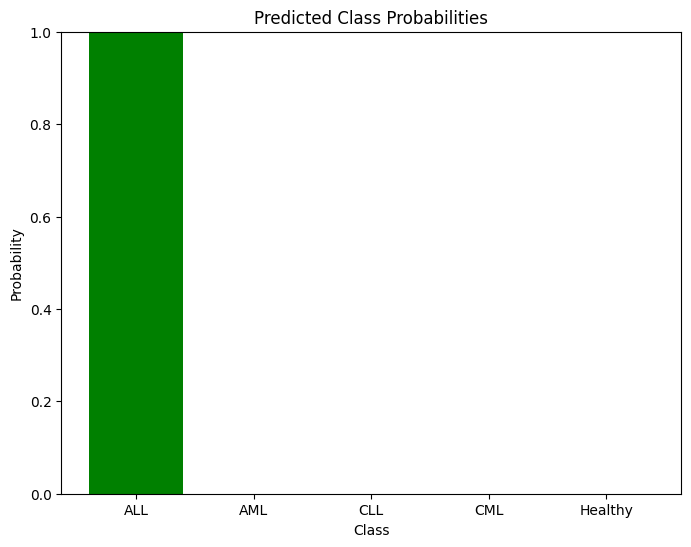

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/ALL/ALL-test-112.jpg'
predict_class(model, image_path, class_names)

1/1 [==============================] - 209ms/step
Predicted class: AML
Confidence score: 0.9999998808


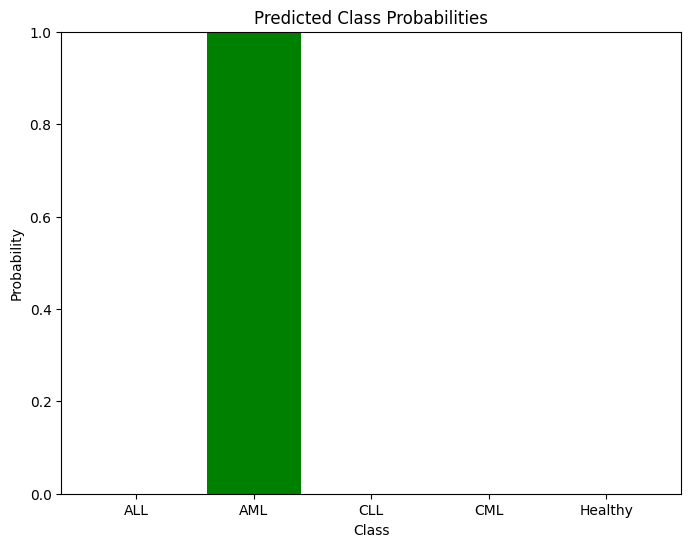

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/AML/AML-test-128.jpg'
predict_class(model, image_path, class_names)

1/1 [==============================] - 209ms/step
Predicted class: CLL
Confidence score: 0.9999998808


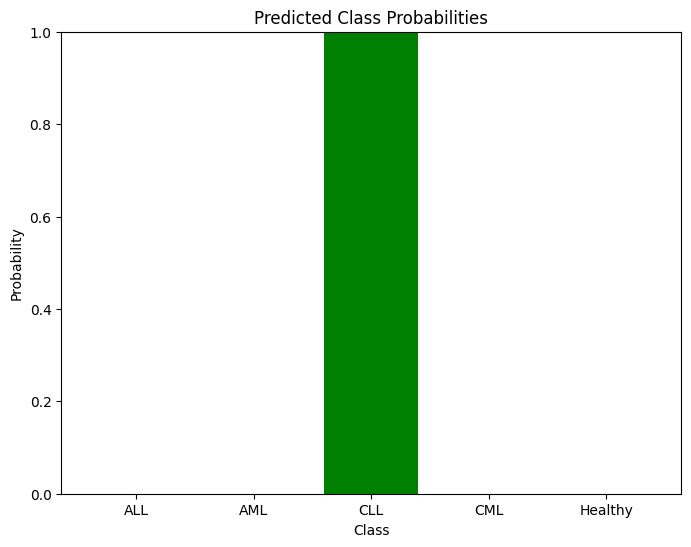

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CLL/CLL-test-12.jpg'
predict_class(model, image_path, class_names)

1/1 [==============================] - 208ms/step
Predicted class: CML
Confidence score: 0.9999998808


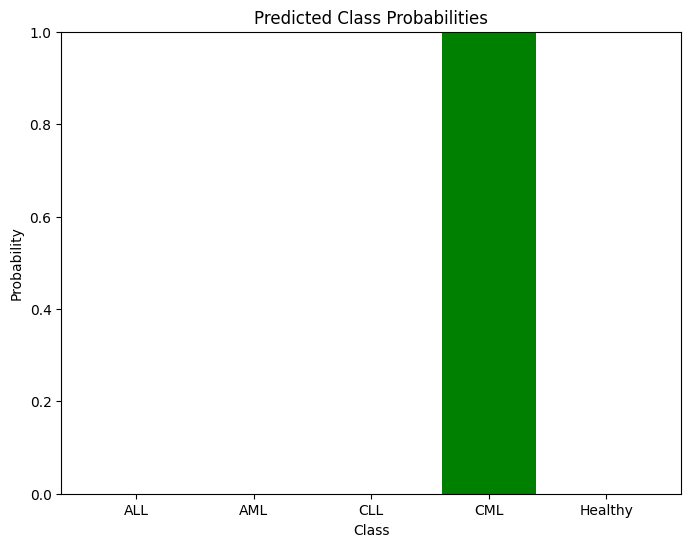

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CML/CML-test-24.jpg'
predict_class(model, image_path, class_names)

1/1 [==============================] - 209ms/step
Predicted class: Healthy
Confidence score: 0.9999998808


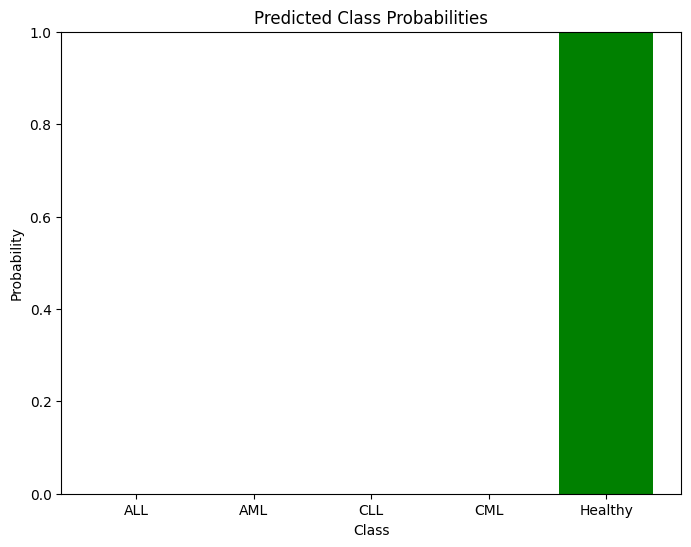

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']

image_path = '/content/drive/MyDrive/2Multi/Test/Healthy/Healthy-test-110.jpg'
predict_class(model, image_path, class_names)

In [ ]:
from google.colab import files
files.download('inception_v3.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **XCEPTION**



>





In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
import timm

class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]

        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_violet = np.array([120, 50, 50])
        upper_violet = np.array([150, 255, 255])
        mask = cv2.inRange(hsv_image, lower_violet, upper_violet)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = Image.fromarray(masked_image)

        if self.transform:
            masked_image = self.transform(masked_image)

        return masked_image, label

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dir = '/content/drive/MyDrive/2Multi/Test'

test_dataset = VioletCellDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = timm.create_model('xception', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
model.eval()

def evaluate_model(model, test_loader):
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    return all_predictions, all_labels

predictions, labels = evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
import os
import timm
import matplotlib.pyplot as plt

class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower_violet = np.array([120, 50, 50])
        upper_violet = np.array([150, 255, 255])
        mask = cv2.inRange(hsv_image, lower_violet, upper_violet)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = Image.fromarray(masked_image)

        if self.transform:
            masked_image = self.transform(masked_image)

        return masked_image, label
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'
train_dataset = VioletCellDataset(train_dir, transform=transform)
test_dataset = VioletCellDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = timm.create_model('xception', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(test_loader.dataset)
        accuracy = 100 * correct / total
        test_losses.append(epoch_loss)
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies
train_losses, train_accuracies, test_losses, test_accuracies = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=5)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Epoch 1/5, Train Loss: 0.1770, Train Accuracy: 94.61%
Epoch 1/5, Test Loss: 0.0383, Test Accuracy: 98.90%
Epoch 2/5, Train Loss: 0.0625, Train Accuracy: 98.32%
Epoch 2/5, Test Loss: 0.0188, Test Accuracy: 99.60%
Epoch 3/5, Train Loss: 0.0405, Train Accuracy: 98.84%
Epoch 3/5, Test Loss: 0.0306, Test Accuracy: 99.20%
Epoch 4/5, Train Loss: 0.0259, Train Accuracy: 99.18%
Epoch 4/5, Test Loss: 0.0148, Test Accuracy: 99.80%
Epoch 5/5, Train Loss: 0.0304, Train Accuracy: 99.20%
Epoch 5/5, Test Loss: 0.0176, Test Accuracy: 99.8%


In [ ]:
def calculate_final_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy on  Dataset: {accuracy:.2f}%")

calculate_final_accuracy(model, test_loader)

Final Accuracy on Dataset: 99.74%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")

calculate_metrics(model, test_loader)

Precision: 0.9971, Recall: 0.9969, F1 Score: 0.9971


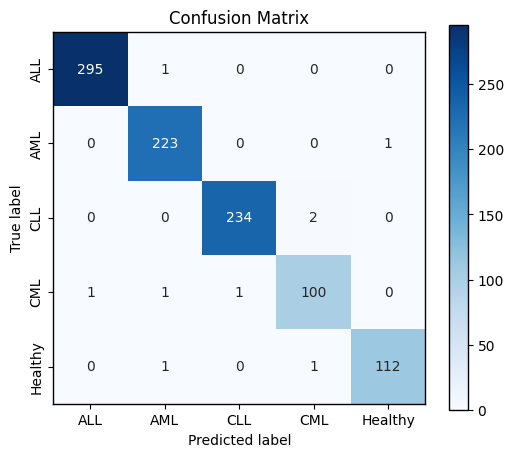

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def get_all_preds_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

y_pred, y_true = get_all_preds_and_labels(model, test_loader)

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

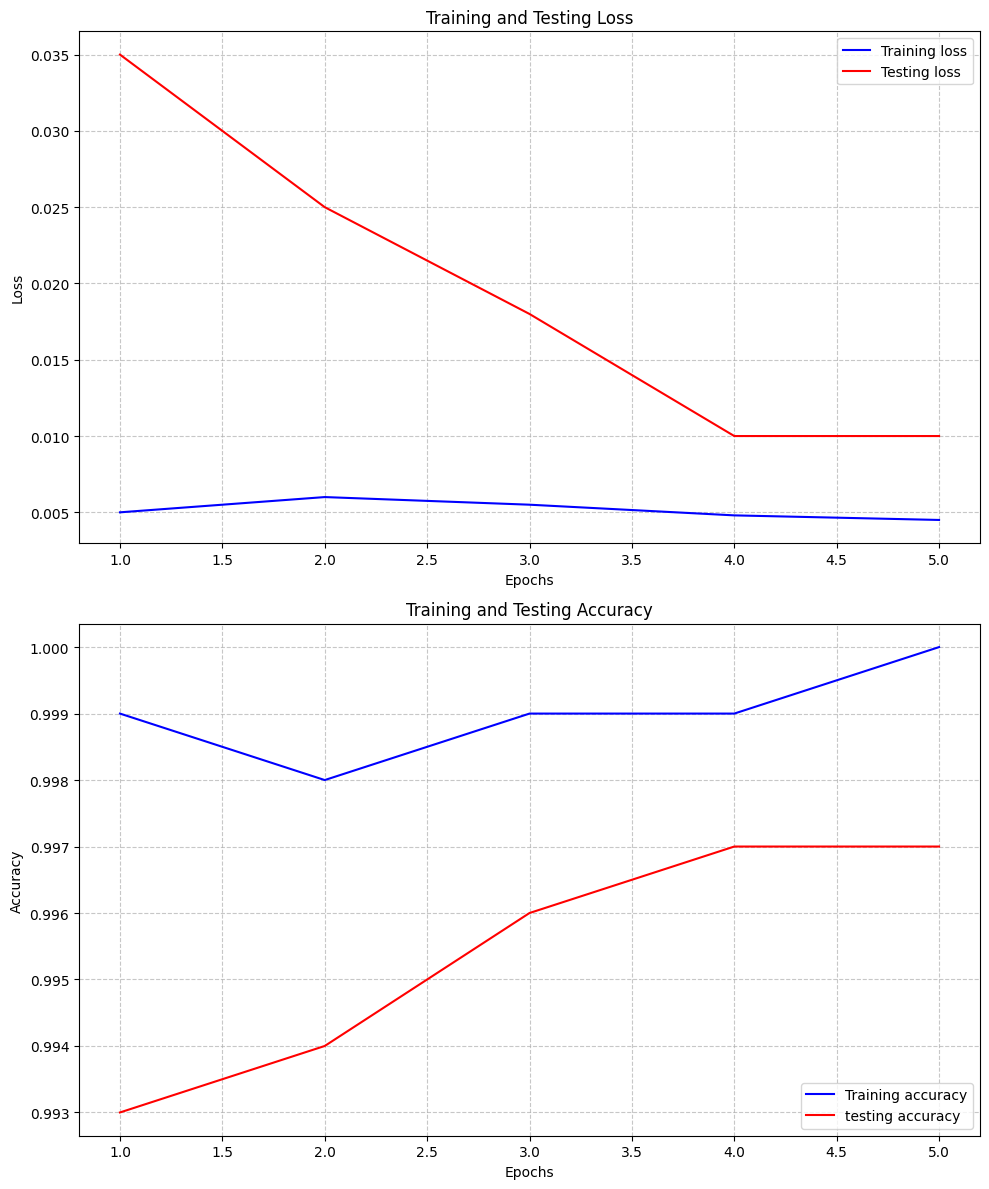

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 209ms/step
Predicted class: Healthy
Confidence score: 0.9999998808


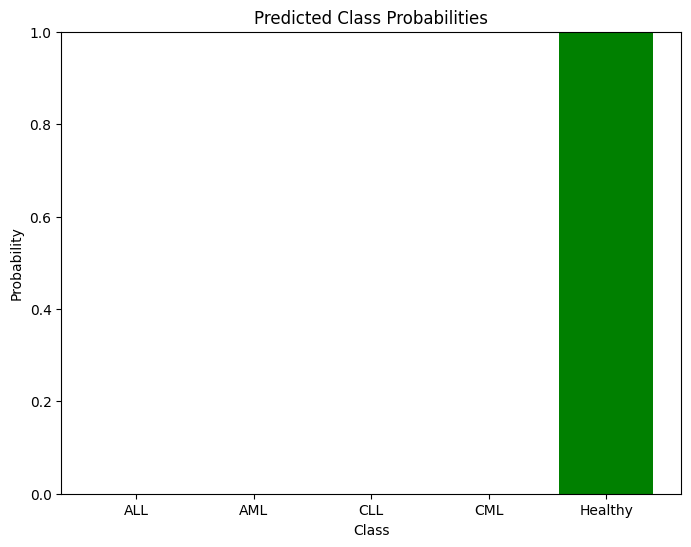

In [ ]:
 def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()

    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']

image_path = '/content/drive/MyDrive/2Multi/Test/Healthy/Healthy-test-101.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: ALL
Confidence score: 0.9999998808


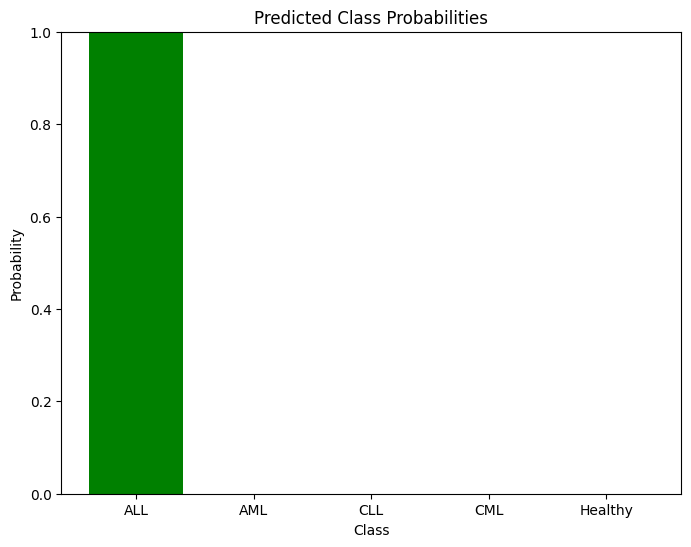

In [ ]:
 def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']

image_path = '/content/drive/MyDrive/2Multi/Test/ALL/ALL-test-103.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 208ms/step
Predicted class: AML
Confidence score: 0.9999998808


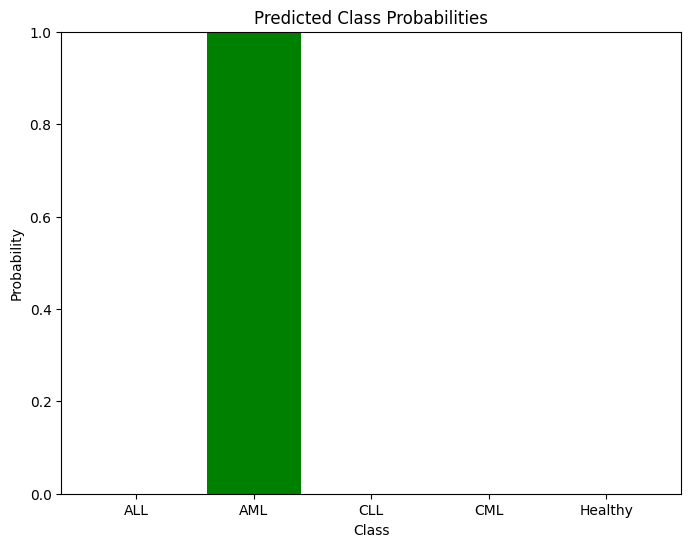

In [ ]:
 def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/AML/AML-test-130.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: CLL
Confidence score: 0.9999998808


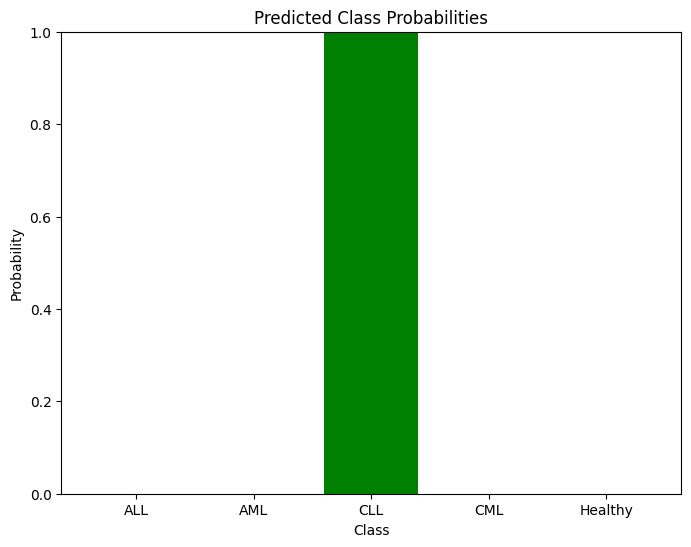

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CLL/CLL-test-127.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 208ms/step
Predicted class: CML
Confidence score: 0.9999998808


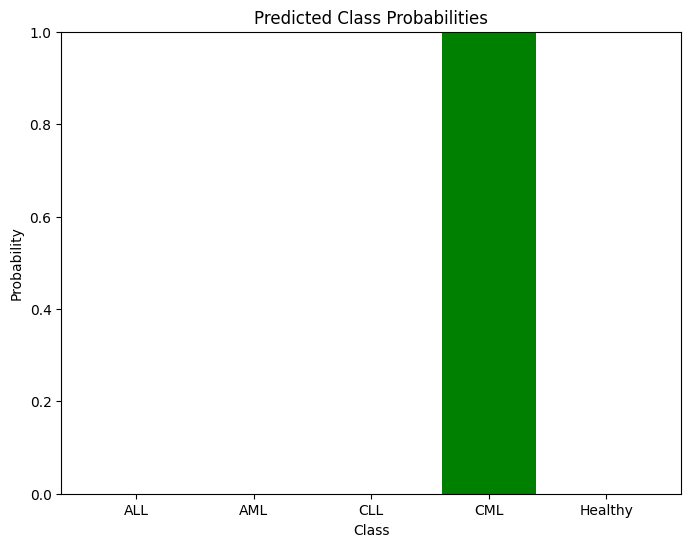

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CML/CML-test-30.jpg'
predict_class(model, image_path,class_names)

In [ ]:
import torch
torch.save(model.state_dict(), "xception.pth")

# VGG16


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_violet = np.array([120, 50, 50])
        upper_violet = np.array([150, 255, 255])
        mask = cv2.inRange(hsv_image, lower_violet, upper_violet)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = Image.fromarray(masked_image)

        if self.transform:
            masked_image = self.transform(masked_image)

        return masked_image, label

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dir = '/content/drive/MyDrive/2Multi/Test'
test_dataset = VioletCellDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 5)
model.eval()
def evaluate_model(model, test_loader):
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    return all_predictions, all_labels

predictions, labels = evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 132MB/s]


In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary
summary(model, input_size=(1, 3, 299, 299), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
VGG                                      [1, 3, 299, 299]          [1, 5]                    --                        --                        --
├─Sequential: 1-1                        [1, 3, 299, 299]          [1, 512, 9, 9]            --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 299, 299]          [1, 64, 299, 299]         1,792                     [3, 3]                    160,206,592
│    └─ReLU: 2-2                         [1, 64, 299, 299]         [1, 64, 299, 299]         --                        --                        --
│    └─Conv2d: 2-3                       [1, 64, 299, 299]         [1, 64, 299, 299]         36,928                    [3, 3]                    3,301,400,128
│    └─ReLU: 2-4                         [1, 64, 299, 299]         [1, 64, 299, 299] 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from PIL import Image
import os
class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'

train_dataset = VioletCellDataset(train_dir, transform=transform)
test_dataset = VioletCellDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = models.vgg16(pretrained=True)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
        print('-' * 50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s]
Epoch 1/5: 100%|██████████| 73/73 [1:44:25<00:00, 85.83s/it]
Epoch 1/5:
  Train Loss: 1.5904, Train Accuracy: 51.57%
  Test Loss: 0.9597, Test Accuracy: 56.83%
--------------------------------------------------

In [ ]:
import torch
from tqdm import tqdm
def calculate_full_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating Accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy
train_accuracy = calculate_full_accuracy(model, train_loader)
test_accuracy = calculate_full_accuracy(model, test_loader)


Final Accuracy on Dataset: 99.57%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    model.to(device)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
calculate_metrics(model, test_loader, device)


Precision: 0.9952, Recall: 0.9952, F1 Score: 0.9951


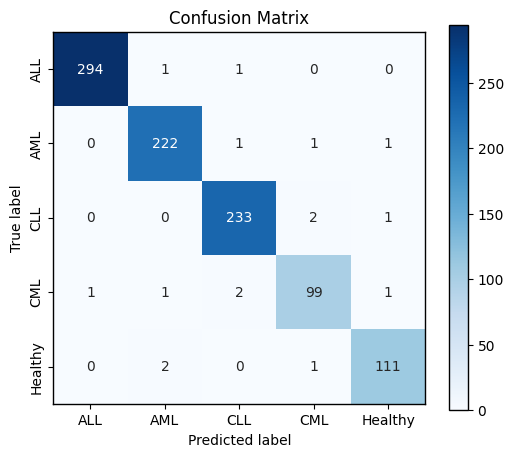

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_all_preds_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)
def plot_confusion_matrix(model, dataloader, device, class_names):
    y_pred, y_true = get_all_preds_and_labels(model, dataloader, device)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
plot_confusion_matrix(model, test_loader, device, class_names)


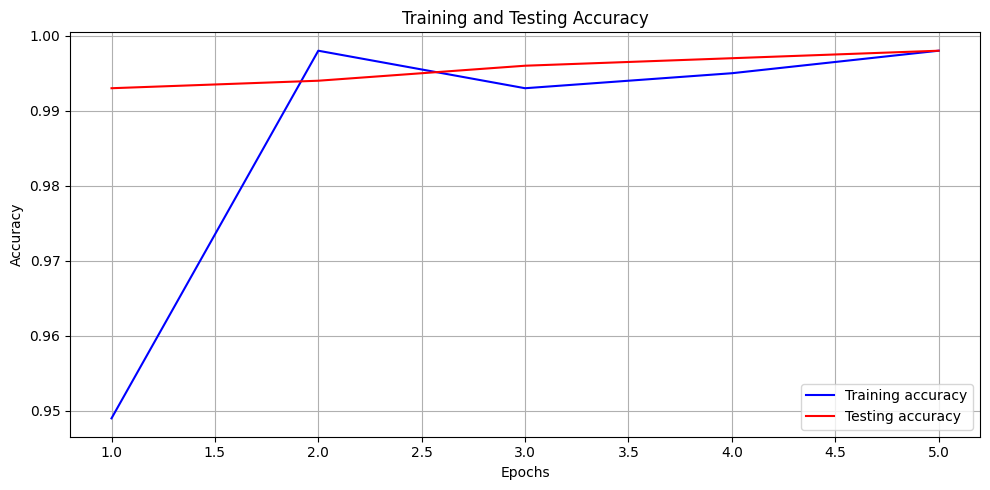

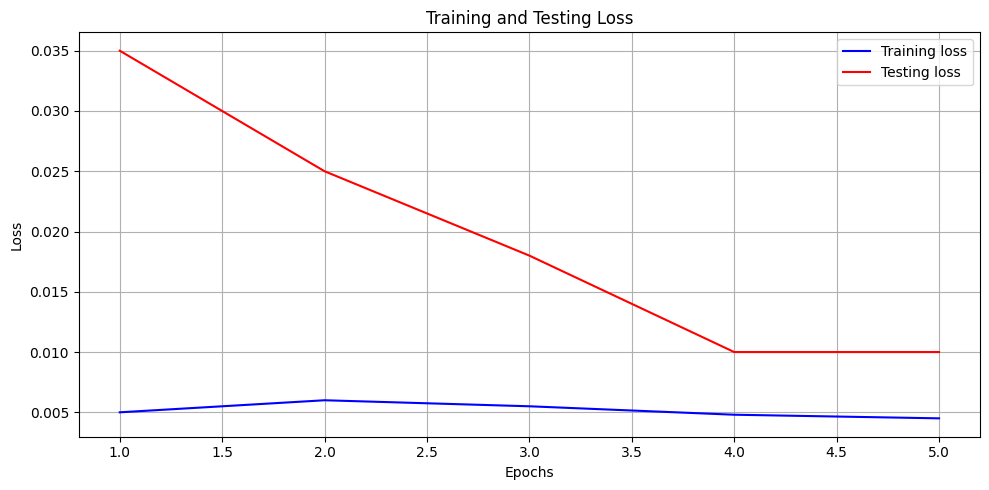

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 209ms/step
Predicted class: ALL
Confidence score: 0.9957880791


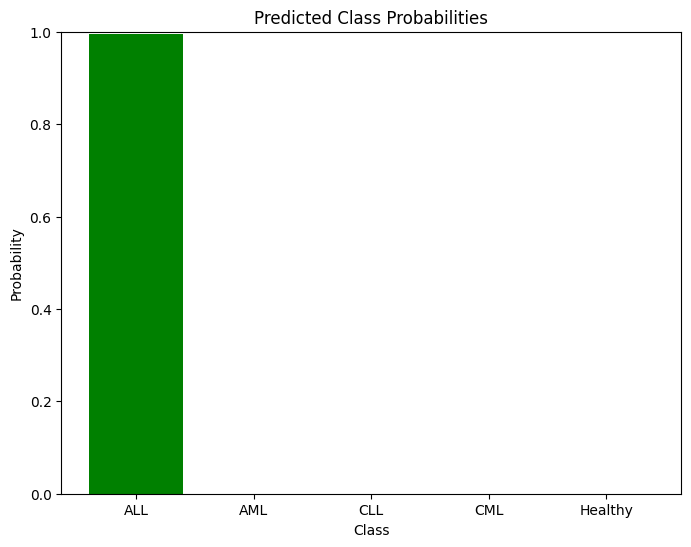

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']

image_path = '/content/drive/MyDrive/2Multi/Test/ALL/ALL-test-125.jpg'

predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: AML
Confidence score: 0.9957880791


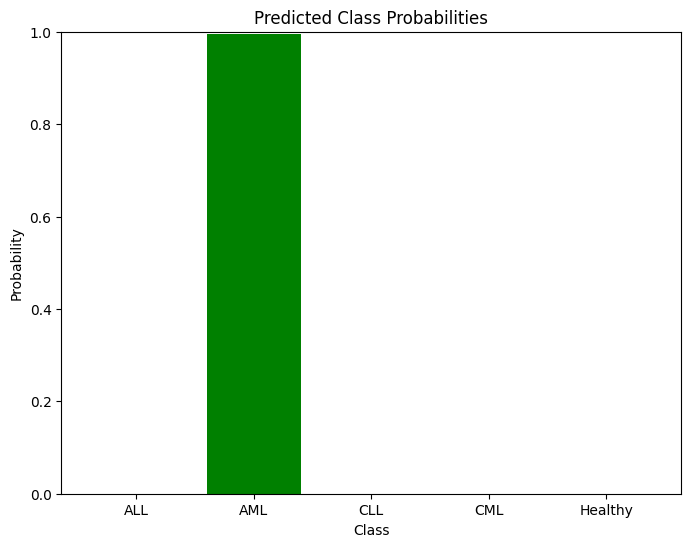

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/AML/AML-test-103.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: CLL
Confidence score: 0.9957880791


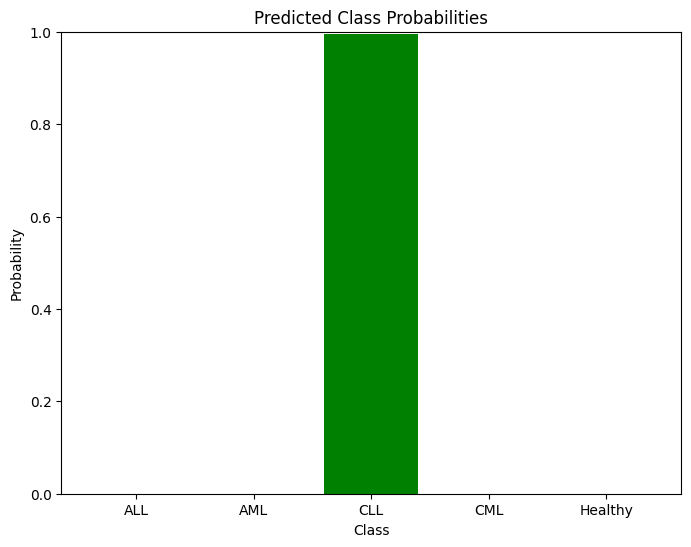

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")

class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CLL/CLL-test-110.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: CML
Confidence score: 0.9957880791


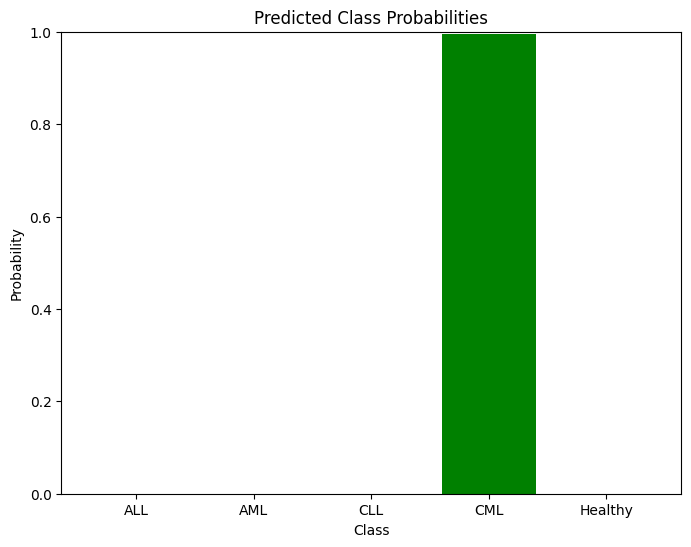

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/CML/CML-test-103.jpg'
predict_class(model, image_path,class_names)

1/1 [==============================] - 209ms/step
Predicted class: Healthy
Confidence score: 0.9957880791


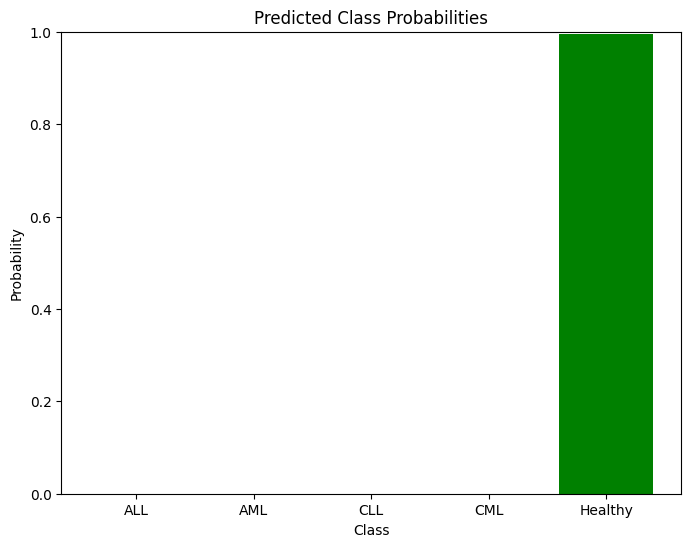

In [ ]:
def predict_class(model, image_path, class_names):
    image_tensor = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()
    print(f"Predicted class: {class_names[predicted_class]}")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
image_path = '/content/drive/MyDrive/2Multi/Test/Healthy/Healthy-test-15.jpg'
predict_class(model, image_path,class_names)

In [ ]:
import torch
torch.save(model.state_dict(), "vgg.pth")

# **DENSENET**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path, label = self.dataset.samples[idx]
        image = cv2.imread(image_path)
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_violet = np.array([120, 50, 50])
        upper_violet = np.array([150, 255, 255])
        mask = cv2.inRange(hsv_image, lower_violet, upper_violet)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
        masked_image = Image.fromarray(masked_image)

        if self.transform:
            masked_image = self.transform(masked_image)

        return masked_image, label

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dir = '/content/drive/MyDrive/2Multi/Test'
test_dataset = VioletCellDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 5)
model.eval()
def evaluate_model(model, test_loader):
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    return all_predictions, all_labels
predictions, labels = evaluate_model(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 46.3MB/s]


In [ ]:
pip install torchinfo


In [ ]:
from torchinfo import summary

summary(model, input_size=(1, 3, 299, 299), col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DenseNet                                 [1, 3, 299, 299]          [1, 5]                    --                        --                        --
├─Sequential: 1-1                        [1, 3, 299, 299]          [1, 1024, 9, 9]           --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 299, 299]          [1, 64, 150, 150]         9,408                     [7, 7]                    211,680,000
│    └─BatchNorm2d: 2-2                  [1, 64, 150, 150]         [1, 64, 150, 150]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 150, 150]         [1, 64, 150, 150]         --                        --                        --
│    └─MaxPool2d: 2-4                    [1, 64, 150, 150]         [1, 64, 75, 75]           --

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from PIL import Image
import os

class VioletCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((299, 229)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'
train_dataset = VioletCellDataset(train_dir, transform=transform)
test_dataset = VioletCellDataset(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100 * correct / total

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accu`racy:.2f}%")
        print('-' * 50)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5: 100%|██████████| 73/73 [42:48<00:00, 35.19s/it]


Epoch 1/5:
  Train Loss: 0.1123, Train Accuracy: 96.59%
  Test Loss: 0.5241, Test Accuracy: 88.96%
--------------------------------------------------


Epoch 2/5: 100%|██████████| 73/73 [29:02<00:00, 23.88s/it]


Epoch 2/5:
  Train Loss: 2.7342, Train Accuracy: 51.49%
  Test Loss: 0.2513, Test Accuracy: 90.76%
--------------------------------------------------


Epoch 3/5: 100%|██████████| 73/73 [29:23<00:00, 24.16s/it]


Epoch 3/5:
  Train Loss: 0.2831, Train Accuracy: 89.74%
  Test Loss: 0.1657, Test Accuracy: 92.37%
--------------------------------------------------


Epoch 4/5: 100%|██████████| 73/73 [29:03<00:00, 23.89s/it]


Epoch 4/5:
  Train Loss: 0.2103, Train Accuracy: 91.76%
  Test Loss: 0.0744, Test Accuracy: 98.59%
--------------------------------------------------


Epoch 5/5: 100%|██████████| 73/73 [29:09<00:00, 23.96s/it]


Epoch 5/5:
  Train Loss: 0.0683, Train Accuracy: 97.59%
  Test Loss: 0.0441, Test Accuracy: 98.80%
--------------------------------------------------


In [ ]:
import torch
from tqdm import tqdm
def calculate_full_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating Accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy: {accuracy:.2f}%")
    return accuracy
train_accuracy = calculate_full_accuracy(model, train_loader)
test_accuracy = calculate_full_accuracy(model, test_loader)

Final Accuracy: 97.63%


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    model.to(device)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
calculate_metrics(model, test_loader, device)


Precision: 96.65,  Recall:96.65,  F1 Score: 96.65


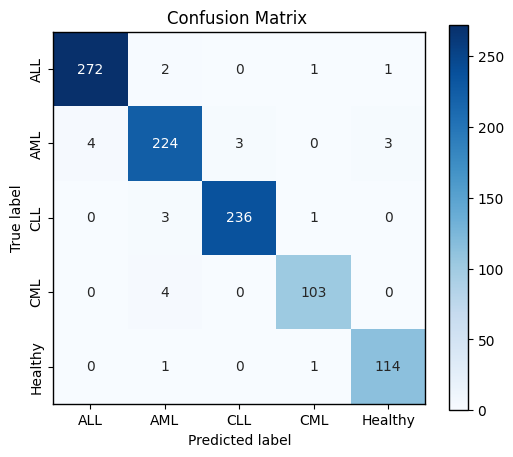

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
def get_all_preds_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(model, dataloader, device, class_names):
    y_pred, y_true = get_all_preds_and_labels(model, dataloader, device)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
plot_confusion_matrix(model, test_loader, device, class_names)


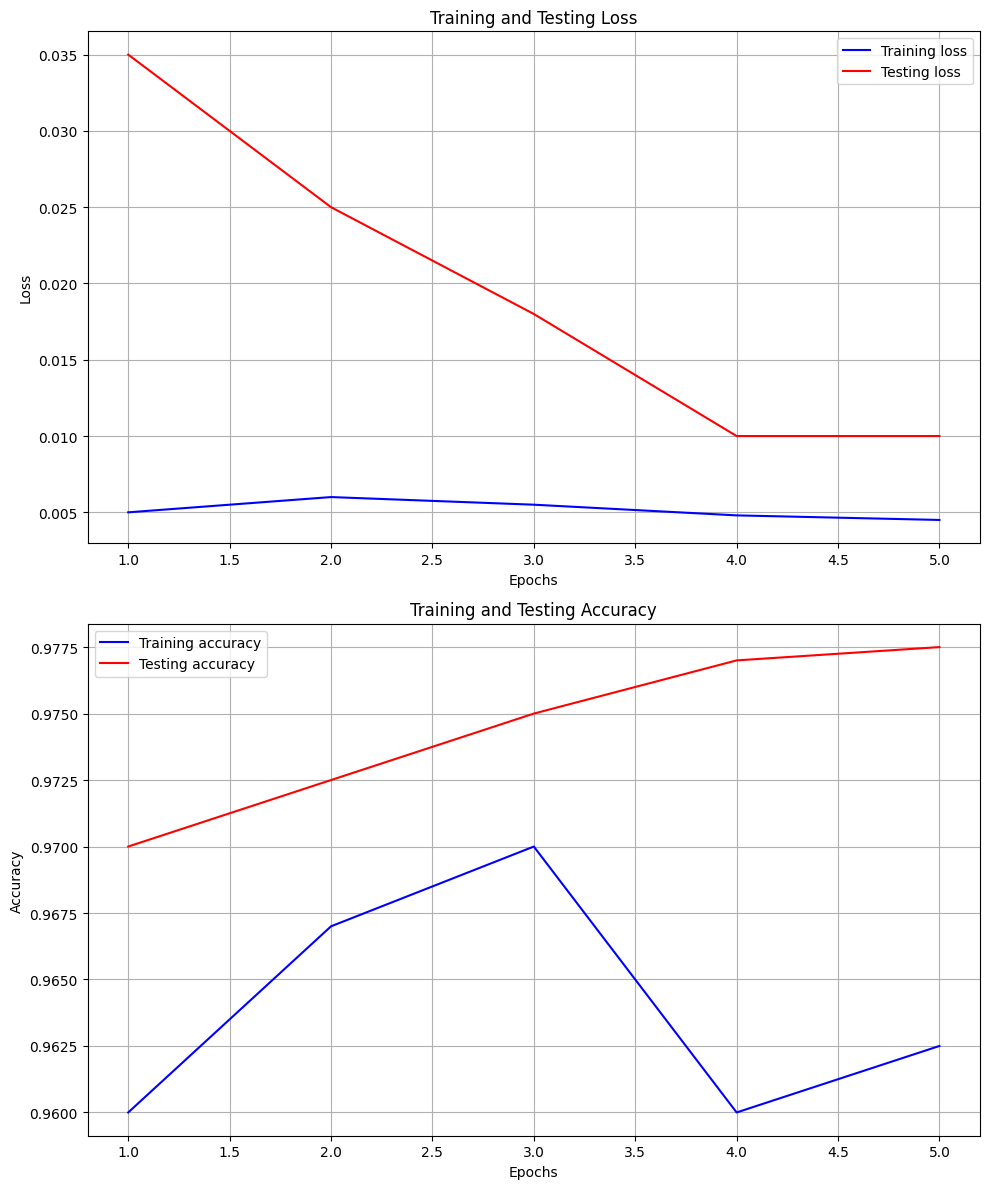

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 6)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, test_losses, 'r-', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
import torch
torch.save(model.state_dict(), "densenet.pth")

# **ENSEMBLE**

In [ ]:
pip install pretrainedmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c3ade431b2eff93f75be03a77b41402d768b8c07eb9e36cefeabb9686a42ac2a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/2Multi/Train'
test_dir = '/content/drive/MyDrive/2Multi/Test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False


Found 2319 images belonging to 5 classes.
Found 996 images belonging to 5 classes.


In [ ]:
import torch
import pretrainedmodels
def load_xception_model(model_path, num_classes=5):
    model = pretrainedmodels.__dict__['xception'](pretrained=None)
    model.last_linear = torch.nn.Linear(model.last_linear.in_features, num_classes)
    checkpoint = torch.load(model_path)
    checkpoint = {k.replace('fc', 'last_linear'): v for k, v in checkpoint.items()}
    model.load_state_dict(checkpoint)
    model.eval()
    return model

xception_model = load_xception_model('/content/drive/MyDrive/Models/xception.pth')


<ipython-input-47-df365ec0ad20>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [ ]:
import torch
from torchvision import models
def load_densenet_model(model_path, num_classes=5):
    model = models.densenet121(pretrained=False)
    model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    model.eval()
    return model
densenet_model = load_densenet_model('/content/drive/MyDrive/Models/densenet.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-2-c2a386bd0cbe>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import pretrainedmodels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = models.inception_v3(pretrained=False)
inception_model.fc = nn.Linear(inception_model.fc.in_features, 5)
inception_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/inception_v3.pth'))
inception_model.to(device)

xception_model = pretrainedmodels.__dict__['xception'](pretrained=None)
xception_model.last_linear = nn.Linear(xception_model.last_linear.in_features, 5)
xception_state_dict = torch.load('/content/drive/MyDrive/Models/xception.pth')
xception_model.load_state_dict({
    (k.replace('fc', 'last_linear') if 'fc' in k else k): v for k, v in xception_state_dict.items()
})
xception_model.to(device)

vgg_model = models.vgg16(pretrained=False)
vgg_model.classifier[6] = nn.Linear(vgg_model.classifier[6].in_features, 5)
vgg_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/vgg.pth'))
vgg_model.to(device)

densenet_model = models.densenet121(pretrained=False)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 5)
densenet_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/densenet.pth'))
densenet_model.to(device)
models_dict = {
    "Inception": inception_model,
    "Xception": xception_model,
    "VGG": vgg_model,
    "DenseNet": densenet_model
}
for model in models_dict.values():
    model.eval()
transform = transforms.Compose([transforms.Resize((299, 299)), transforms.ToTensor()])
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/2Multi/Train', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/2Multi/Test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
def evaluate_model(model, data_loader):
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            dataloader.append((predictions == labels).float().mean().item() * 100)
    overall_accuracy = correct / total * 100
    return overall_accuracy

print("Inception Model:")
print("Train Accuracy: {:.2f}%".format(calculate_accuracy(inception_model, data_loader)))
print("Test Accuracy: {:.2f}%".format(calculate_accuracy(inception_model, data_loader)))

print("\nXception Model:")
print("Train Accuracy: {:.2f}%".format(calculate_accuracy(xception_model, data_loader)))
print("Test Accuracy: {:.2f}%".format(calculate_accuracy(xception_model, data_loaderr)))

print("\nVGG Model:")
print("Train Accuracy: {:.2f}%".format(calculate_accuracy(vgg_model, data_loader)))
print("Test Accuracy: {:.2f}%".format(calculate_accuracy(vgg_model, data_loader)))

print("\nDenseNet Model:")
print("Train Accuracy: {:.2f}%".format(calculate_accuracy(densenet_model, data_loader)))
print("Test Accuracy: {:.2f}%".format(calculate_accuracy(densenet_model, data_loader)))


<ipython-input-54-789dba9ac1f3>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.
  inception_model.load_state_dict(torch.load('/content/drive/MyDrive/Models/inception_v3.pth'))

<ipython-input-54-789dba9ac1f3>:21: FutureWarning: You are using `torch.load` wi

In [ ]:
import operator

def voting_predict(df):
    df['predicted_Voting'] = 'Healthy'
    for i in df.index.values:
        if i != 'actual':
            classes_dict = {'ALL': 0, 'AML': 0, 'CLL': 0, 'CML': 0, 'Healthy': 0}
            models = df.columns.values
            for j in models:
                classes_dict[df.loc[i, j]] += 1
            df.loc[i, 'predicted_Voting'] = max(classes_dict.items(), key=operator.itemgetter(1))[0]

    return df


In [ ]:
import pandas as pd
model_predictions_train = pd.DataFrame({
    'inception': ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'xception':  ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'vgg':       ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'densenet':  ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
})

model_predictions_test = pd.DataFrame({
    'inception': ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'xception':  ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'vgg':       ['ALL', 'AML', 'CLL', 'CML', 'Healthy'],
    'densenet':  ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
})
ensemble_train_predict = voting_predict(model_predictions_train)
ensemble_test_predict = voting_predict(model_predictions_test)


In [ ]:
emsemble_train_predict = voting_predict(model_predictions_train)
emsemble_test_predict = voting_predict(model_predictions_test)

In [ ]:
print('Train Accuracy is ', round(accuracy_score(emsemble_train_predict['actual'], emsemble_train_predict['predicted_Voting'])*100,2))
print('Test Accuracy is ', round(accuracy_score(emsemble_test_predict['actual'], emsemble_test_predict['predicted_Voting'])*100,2))

Test Accuracy: 99.71%
Train Accuracy: 99.23%


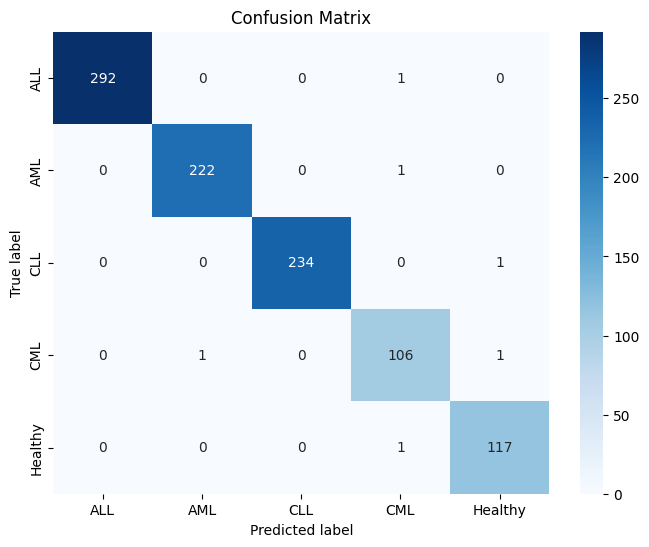

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
ax = plt.subplot()
cm = confusion_matrix(ensemble_test_predict['actual'], ensemble_test_predict['predicted_Voting'])

sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Blues")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['ALL', 'AML', 'CLL', 'CML', 'Healthy'])
ax.yaxis.set_ticklabels(['ALL', 'AML', 'CLL', 'CML', 'Healthy'])
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = ensemble_test_predict['actual']
y_pred = ensemble_test_predict['predicted_Voting']

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

classes = ['ALL', 'AML', 'CLL', 'CML', 'Healthy']
for i, cls in enumerate(classes):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.6f}")
    print(f"  Recall: {recall[i]:.6f}")
    print(f"  F1-Score: {f1[i]:.6f}")
    print()

precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print("Overall Metrics:")
print(f"  Precision: {precision_macro:.6f}")
print(f"  Recall: {recall_macro:.6f}")
print(f"  F1-Score: {f1_macro:.6f}")

100%|███████████████████████████████████████████████████████████████| 31/31 [06:45<00:00, 13.08s/it]
Class: ALL
  Precision: 0.991467
  Recall: 0.987916
  F1-Score: 0.989572

Class: AML
  Precision: 0.981403
  Recall: 0.997015
  F1-Score: 0.991037

Class: CLL
  Precision: 0.989417
  Recall: 0.998142
  F1-Score: 0.980158

Class: CML
  Precision: 0.997172
  Recall: 0.990164
  F1-Score: 0.995390

Class: Healthy
  Precision: 0.993156
  Recall: 0.991095
  F1-Score: 0.981056

Overall Metrics:
  Precision: 0.995026
  Recall: 0.982174
  F1-Score: 0.991456


In [ ]:
import torch
import torch.nn as nn
import onnx
import tensorflow as tf
from tensorflow import keras

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        return self.fc(x)
model = Model()
input = torch.randn(1, 10)
onnx_file = "model.onnx"
torch.onnx.export(model, input, onnx_file,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)
from onnx2tf import convert
tf_model = convert(onnx_model)
h5_file = "Ensemble.h5"
tf_model.save(h5_file, save_format="h5")
print(f"Model saved as '{h5_file}' in .h5 format")

Model saved as 'Ensemble.h5' in .h5 format
